### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATAION`

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


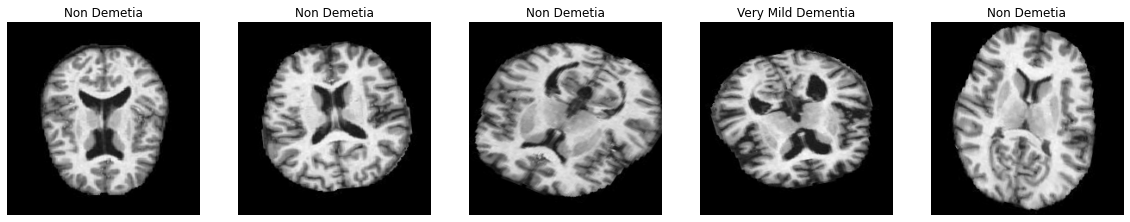

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [6]:
# Model Initialization

base_model = DenseNet201(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

74842112/74836368 [==============================] - 1s 0us/step


In [7]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [9]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1920)        0         
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 94080)             376320    
_________________________________________________________________
dense (Dense)                (None, 2048)              192677888 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [11]:
# Model Compile 

OPT = tensorflow.keras.optimizers.Adam(lr = 0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [12]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 1.3954 - auc: 0.7874
Epoch 00001: val_auc improved from -inf to 0.73234, saving model to ./best_weights.hdf5
33/33 [==============================] - 75s 2s/step - loss: 1.3954 - auc: 0.7874 - val_loss: 2.6341 - val_auc: 0.7323
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 1.1169 - auc: 0.8296
Epoch 00002: val_auc did not improve from 0.73234
33/33 [==============================] - 57s 2s/step - loss: 1.1169 - auc: 0.8296 - val_loss: 2.3110 - val_auc: 0.6299
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 0.9664 - auc: 0.8560
Epoch 00003: val_auc did not improve from 0.73234
33/33 [==============================] - 58s 2s/step - loss: 0.9664 - auc: 0.8560 - val_loss: 1.7434 - val_auc: 0.6726
Epoch 4/500
33/33 [==============================] - ETA: 0s - loss: 0.9050 - auc: 0.8665
Epoch 00004: val_auc did not improve from 0.73234
33/33 [==============================] - 58s 

Epoch 32/500
33/33 [==============================] - ETA: 0s - loss: 0.5184 - auc: 0.9511
Epoch 00032: val_auc did not improve from 0.86568
33/33 [==============================] - 56s 2s/step - loss: 0.5184 - auc: 0.9511 - val_loss: 1.2057 - val_auc: 0.8493
Epoch 33/500
33/33 [==============================] - ETA: 0s - loss: 0.5076 - auc: 0.9526
Epoch 00033: val_auc did not improve from 0.86568
33/33 [==============================] - 55s 2s/step - loss: 0.5076 - auc: 0.9526 - val_loss: 1.1368 - val_auc: 0.8604
Epoch 00033: early stopping
